# loading the datasets

In [1]:
!pip install datasets

In [2]:
!pip install -U datasets


In [1]:
from datasets import load_dataset

ds = load_dataset("ruslanmv/ai-medical-chatbot")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# 1. Tokenization

**Creating tokens and assigning token IDs to each**

subword tokenization - using BPE
low vocab size ---> No OOV problem (both chacracters and subwords present; so any new word can be be tokenized as well)

Original Gemma3 model size is 262k. But, we will use 50257 for simplicity. We will use tiktoken library for tokenization. We will store the token IDs as file in disk after seperating them into train and validation files.

In [ ]:
import tiktoken
import os
import numpy as np
import tqdm.auto as tqdm
import torch

enc = tiktoken.get_encoding("gpt2")


def process(example):
    # Combine condition_label + abstract into a single string
    text = f"Condition: {example['condition_label']}\nAbstract: {example['medical_abstract']}"
    ids_all = enc.encode(text)  # use encode, not encode_ordinary
    return {"ids": ids_all, "len": len(ids_all)}

**for whole data**

In [2]:


# 90/10 split
splits = ds["train"].train_test_split(test_size=0.1, seed=42)
train_ds = splits["train"]
val_ds = splits["test"]


In [9]:
train_ds

Dataset({
    features: ['Description', 'Patient', 'Doctor'],
    num_rows: 231224
})

In [16]:
def process(example):
    # build one text string first

    text = (
        f"Description: {example['Description']}\n"
        f"Patient query: {example['Patient']}\n"
        f"Doctor's response: {example['Doctor']}\n"
        "<|endoftext|>\n"   # special separator
    )
    #ids_all = enc.encode(text)
    ids_all = enc.encode(text, allowed_special={"<|endoftext|>"})
    return {"ids": ids_all, "len": len(ids_all)}




In [17]:
#now taking the process function and applying to every row of dataset

train_tok = train_ds.map(
    process,
    remove_columns=["Description", "Patient", "Doctor"],
    desc="Tokenizing train set",
    num_proc=8,
)

val_tok = val_ds.map(
    process,
    remove_columns=["Description", "Patient", "Doctor"],
    desc="Tokenizing val set",
    num_proc=8,
)

Tokenizing train set (num_proc=8):   0%|          | 0/231224 [00:00<?, ? examples/s]

Tokenizing val set (num_proc=8):   0%|          | 0/25692 [00:00<?, ? examples/s]

In [18]:
import numpy as np
from tqdm import tqdm

def save_bin(dset, filename):
    arr_len = np.sum(dset["len"], dtype=np.uint64)
    arr = np.memmap(filename, dtype=np.uint16, mode="w+", shape=(arr_len,))
    total_batches = 1024
    idx = 0
    for batch_idx in tqdm(range(total_batches), desc=f"Writing {filename}"):
        batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format("numpy")
        arr_batch = np.concatenate(batch["ids"])
        arr[idx:idx+len(arr_batch)] = arr_batch
        idx += len(arr_batch)
    arr.flush()
    print(f"✅ Wrote {filename} with {arr_len} tokens")

save_bin(train_tok, "train.bin")
save_bin(val_tok, "val.bin")


Writing train.bin: 100%|██████████| 1024/1024 [01:40<00:00, 10.16it/s]


✅ Wrote train.bin with 58017800 tokens


Writing val.bin: 100%|██████████| 1024/1024 [00:13<00:00, 77.94it/s]

✅ Wrote val.bin with 6461351 tokens


In [ ]:
#checking the contents of the 'train.bin' file

import numpy as np
from transformers import GPT2TokenizerFast

# load bin file
arr = np.memmap("train.bin", dtype=np.uint16, mode="r")

# see first 50 tokens
print("First 50 token IDs:", arr[:2000])

# decode back to text
sample_text = enc.decode(arr[:2000])  # decode first 200 tokens
print("\nDecoded text sample:\n", sample_text)


First 50 token IDs: [11828    25 10358 ...    13 13408   314]

Decoded text sample:
 Description: Should I be concerned about having pain in the left side of my back?
Patient query: I have been having left side pain on the middle of my side but it can be in my back, chest and even my lower right side at times. No other symptoms at all. I had hernia repair with mesh 1 year ago. THe pain is tolerable just annoying. Should I be concerned?
Doctor's response: Hello, The pain on one side of the back can be postural in nature. Standing for long periods and lack of adequate exercise can cause such a pain. Oral muscle relaxants and regular exercises can help. Hope I have answered your query. Let me know if I can assist you further. Take care Regards, Dr Praveen Tayal, Orthopaedic Surgeon
<|endoftext|>
Description: Q. My cuticles have developed blood specks. Is it scleroderma?
Patient query: Hi doctor,I am contacting you because I have Raynaud's, and the past few months my cuticles have develope

# 2. Input-output datasets

np.memmap:

It allows you to access a large binary file on disk without loading the entire file into RAM (only parts of file that are needed). Useful when the dataset is too large to fit into memory.



In [20]:
def get_batch(split):
  if split=="train":
    data= np.memmap('train.bin', dtype= np.uint16, mode= 'r') #uint16 = Each element in the file is stored as an unsigned 16-bit integer
  else:
    data= np.memmap('val.bin', dtype= np.uint16, mode='r')

  ix = torch.randint(len(data) - block_size, (batch_size,))
  x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
  y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])

  if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
  else:
        x, y = x.to(device), y.to(device)
  return x, y


# 3. Model architecture

**ROPE embeddings**

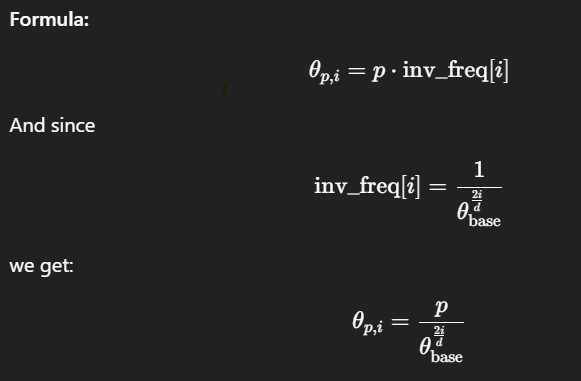

In [22]:
def rope_compute(head_dim, theta_base=10000, dtype= torch.float32, context_length=4096):

  #inv_frequency (indices is the position within one token; inside the head_dim space)


  indices= torch.arange(0, head_dim, 2,dtype=dtype) #arange makes a 1d vector from start to end (head_dim) with step size=2
  fraction = indices.float() / head_dim
  denominator = theta_base ** fraction
  inv_freq= 1/ denominator

  #position calculation (p in the forumla; p is the token position in the context)
  pos=torch.arange(context_length, dtype=dtype)

  #angles
  angle= pos[:, None] * inv_freq[None,:]

  #sine/cosine
  cos= torch.cos(angle)
  sin= torch.sin(angle)

  return cos, sin


def rope_final(x, cos, sin):

  #Unpacking the x matrix
  batch_size, num_heads, seq_len, head_dim= x.shape

  assert head_dim % 2 == 0, "head_dim must be even"

  #split x, 2 indices at a time
  x1= x[..., : head_dim//2]
  x2= x[..., head_dim//2 :]

  cos= cos[:seq_len, :].unsqueeze(0).unsqueeze(0) # Shape is (1, 1, seq_len, head_dim)
  sin= sin[:seq_len, :].unsqueeze(0).unsqueeze(0)

  #apply rotation
  rotated= torch.cat((-x2, x1), dim=-1)
  x_rotated= (x*cos) + (rotated*sin)

  return x_rotated.to(dtype=dtype)





In [23]:
import torch
def rope_compute(head_dim, theta_base=10_000, context_length=4096, dtype=torch.float32):
    assert head_dim % 2 == 0, "Embedding dimension must be even"

    # Compute the inverse frequencies
    inv_freq = 1.0 / (theta_base ** (torch.arange(0, head_dim, 2, dtype=dtype)[: (head_dim // 2)].float() / head_dim))

    # Generate position indices
    positions = torch.arange(context_length, dtype=dtype)

    # Compute the angles
    angles = positions[:, None] * inv_freq[None, :]  # Shape: (context_length, head_dim // 2)

    # Expand angles to match the head_dim
    angles = torch.cat([angles, angles], dim=1)  # Shape: (context_length, head_dim)

    # Precompute sine and cosine
    cos = torch.cos(angles)
    sin = torch.sin(angles)

    return cos, sin


def rope_final(x, cos, sin):
    # x: (batch_size, num_heads, seq_len, head_dim)
    batch_size, num_heads, seq_len, head_dim = x.shape
    assert head_dim % 2 == 0, "Head dimension must be even"

    # Split x into first half and second half
    x1 = x[..., : head_dim // 2]  # First half
    x2 = x[..., head_dim // 2 :]  # Second half

    # Adjust sin and cos shapes
    cos = cos[:seq_len, :].unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, seq_len, head_dim)
    sin = sin[:seq_len, :].unsqueeze(0).unsqueeze(0)

    # Apply the rotary transformation
    rotated = torch.cat((-x2, x1), dim=-1)
    x_rotated = (x * cos) + (rotated * sin)

    # It's ok to use lower-precision after applying cos and sin rotation
    return x_rotated.to(dtype=x.dtype)

# RMS-norm and Attention mechanism

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

In [25]:
class RMS_Norm(nn.Module):
  def __init__(self, emb_dim, eps=1e-6, bias=False):
    super().__init__()
    self.eps=eps
    self.scale= nn.Parameter(torch.zeros(emb_dim))
    self.shift= nn.Parameter(torch.zeros(emb_dim)) if bias else None

    #here we set the bias term (SHIFT) to true or false based on requirements of adding bais to denominator
  def forward(self, x):
    input_dtype= x.dtype
    x_fl= x.float() #math in float32 for numerical stability
    var= x_fl.pow(2).mean(dim=-1, keepdim=True) #dim=-1 is for last dim of X tensor which is (batch, tokens, emb)
    x_norm=x_fl * torch.rsqrt(var + self.eps) #inverse sqt on x_f1
    out = x_norm * (1.0 + self.scale.float())


    if self.shift is not None:
      out= out + self.shift.float()
    return out.to(input_dtype) #same dtype as input



In [26]:
class GQAAttn(nn.Module):
  def __init__(self, num_heads, d_in, num_kv_groups, head_dim=None, qk_norm=False, query_pre_attn_scalar=None, dtype=None, ):
    super().__init__()
    self.num_heads= num_heads
    self.num_kv_groups= num_kv_groups #since its GQA. we will have multiple KV groups instead of unique KV for each head
    self.group_size= num_heads // num_kv_groups #how many heads share same KV groups out of all heads

    head_dim= d_in // num_heads
    self.head_dim =head_dim
    self.d_out= num_heads * head_dim

    #creating query weight matrix. The matrix maintains the same dim as input vector
    self.W_query= nn.Linear(d_in, self.d_out, bias=False, dtype= dtype)

    #KV weight matrices. Creating only num_kv_groups matrices to share the KVamongs heads
    self.W_key= nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype= dtype)
    self.W_value = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)

    self.out_proj = nn.Linear(self.d_out, d_in, bias=False, dtype=dtype)

    if qk_norm:
      self.q_norm= RMS_Norm(head_dim, eps=1e-6)
      self.k_norm = RMS_Norm(head_dim, eps=1e-6)

    else:
            self.q_norm = self.k_norm = None

    if query_pre_attn_scalar is not None:
            self.scaling = (query_pre_attn_scalar) ** -0.5
    else:
            self.scaling = (head_dim) ** -0.5

  def forward(self, x, mask, cos, sin):
    b, num_tokens, _ = x.shape

    queries= self.W_query(x) #(batch, num_tokens, n_heads * d_head)
    keys= self.W_key(x) #(batch, num_tokens, num_kv_grps * head_dim)
    values= self.W_value(x)

    #transposing the dimensions so as to group the tokens per KV-group (much like head-based grouping in MHA)

    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2) #transposing 1,2 dimensions to make (b, num_heads, toekns,head_dim)
    keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2) #grouping by kv_groups
    values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)

    #Optional step:
    if self.q_norm:
      queries= self.q_norm(queries)
    if self.k_norm:
      keys = self.k_norm(keys)



    #RoPE:
    queries= rope_final(queries, cos, sin)
    keys= rope_final(keys, cos, sin)

    #expand k and v to match num_heads: (check image below for more clarity)
    #currently we have (b, num_kv_groups, seq_len, head_dim), where num_kv*head_dim doesnt account for full d_in...becuz we have shown a grouped representation
    #so, to bring back OG dimensions, lets expand the grouping (here 4 heads is one goup). sO, INTERLEAVE just copies and repeats the dimensions 4 times

    keys = keys.repeat_interleave(self.group_size, dim=1) #dim=2 to repeat along cols
    values = values.repeat_interleave(self.group_size, dim=1)

    queries = queries * self.scaling #scaling...check above

    #attention computation
    attn_scores = queries @ keys.transpose(2,3) #sample eg. : (b,h,T,d)@(b,h,d,T)→(b,h,T,T)
    attn_scores = attn_scores.masked_fill(mask, -torch.inf)
    attn_weights= torch.softmax(attn_scores, dim=-1)
    context = (attn_weights @ values).transpose(1, 2).reshape(b, num_tokens, self.d_out)
    return self.out_proj(context)








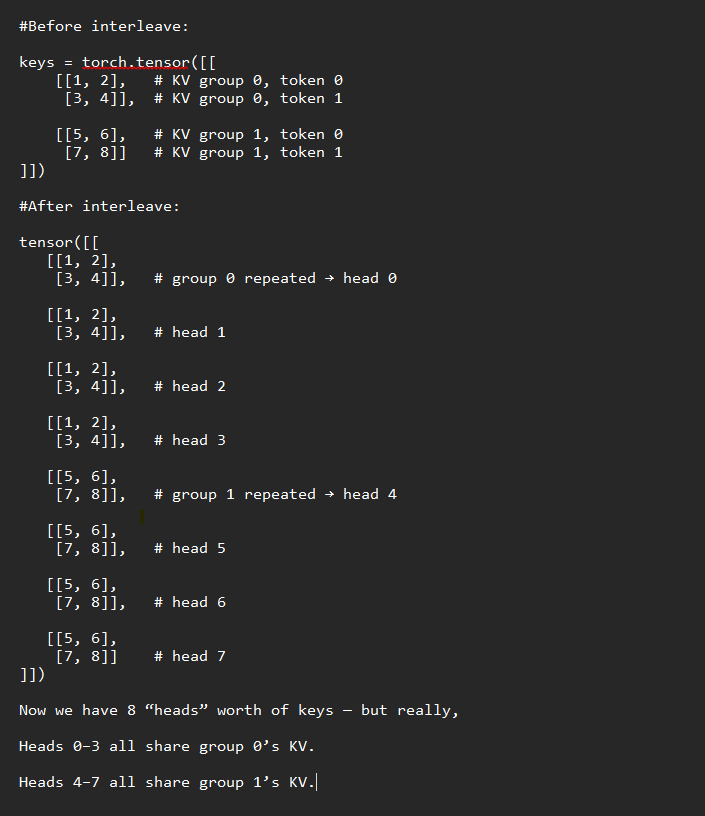

# Feed forward Neural network

In [27]:
class FFNN(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.ff1= nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
    self.ff2 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
    self.ff3 = nn.Linear(cfg["hidden_dim"], cfg["emb_dim"], dtype=cfg["dtype"], bias=False)

  ## Basic design of FFNN:
      # h=GELU(W1​x)⊙(W2​x) #compress steps for ff1,2
      # FFN(x)=W3​(h) #up-project wth ff3

  def forward(self, x):
      x_ff1= self.ff1(x)
      x_ff2= self.ff2(x)
      x= nn.functional.gelu(x_ff1, approximate="tanh") * x_ff2
      return self.ff3(x)






# The transformers block

In [28]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg:dict, attn_type: str):
    super().__init__()
    self.attn_type = attn_type

    self.att= GQAAttn(
        d_in= cfg["emb_dim"],
        num_heads= cfg["n_heads"],
        num_kv_groups= cfg["n_kv_groups"],
        head_dim= cfg["head_dim"],
        qk_norm=cfg["qk_norm"],
        query_pre_attn_scalar=cfg["query_pre_attn_scalar"],
        dtype=cfg["dtype"],
    )
    self.ff= FFNN(cfg)
    self.input_layernorm= RMS_Norm(cfg["emb_dim"], eps=1e-6)
    self.post_attn_layernorm= RMS_Norm(cfg["emb_dim"], eps=1e-6)
    self.pre_ffnn_layernorm= RMS_Norm(cfg["emb_dim"], eps=1e-6)
    self.post_ffnn_layernorm= RMS_Norm(cfg["emb_dim"], eps=1e-6)

  def forward(self, x, mask_global, mask_local, cos_global, sin_global, cos_local,sin_local ):
    shortcut= x
    x=self.input_layernorm(x)

    if self.attn_type == "sliding_window_attn":
      attn_mask = mask_local
      cos = cos_local
      sin= sin_local

    else:
      attn_mask= mask_global
      cos= cos_global
      sin= sin_global

    #attention block:
    x_attn = self.att(x, attn_mask, cos, sin)
    x_attn = self.post_attn_layernorm(x_attn)
    x = shortcut + x_attn

    shortcut=x
    x_ffn= self.pre_ffnn_layernorm(x)
    x_ffn = self.ff(x_ffn)
    x_ffn = self.post_ffnn_layernorm(x_ffn)
    x = shortcut + x_ffn
    return x

In [29]:
class Gemma3(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    assert cfg["layer_types"] is not None and len(cfg["layer_types"])==cfg["n_layers"]
    #1. Embedding step
    self.tok_emb= nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])

    #2. Tranformer block (compute attention and FFNN)
    self.blocks= nn.ModuleList([TransformerBlock(cfg, attn_type)for attn_type in cfg["layer_types"]
        ])

    self.final_norm=RMS_Norm(cfg["emb_dim"], eps=1e-6)
    self.out_head= nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype= cfg["dtype"])
    self.cfg= cfg


    cos_global, sin_global = rope_compute(
            head_dim=cfg["head_dim"],
            theta_base=cfg["rope_base"],
            context_length=cfg["context_length"],
            dtype=torch.float32,
        )
    cos_local, sin_local = rope_compute(
            head_dim=cfg["head_dim"],
            theta_base=cfg["rope_local_base"],
            context_length=cfg["context_length"],
            dtype=torch.float32,
        )

    self.register_buffer("cos_local", cos_local, persistent=False)
    self.register_buffer("sin_local", sin_local, persistent=False)
    self.register_buffer("cos_global", cos_global, persistent=False)
    self.register_buffer("sin_global", sin_global, persistent=False)

  def _create_masks(self, seq_len, device):
        ones = torch.ones((seq_len, seq_len), dtype=torch.bool, device=device)

        # mask_global (future is masked: j > i)
        #     j:  0 1 2 3 4 5 6 7
        #  i
        #     0:  0 1 1 1 1 1 1 1
        #     1:  0 0 1 1 1 1 1 1
        #     2:  0 0 0 1 1 1 1 1
        #     3:  0 0 0 0 1 1 1 1
        #     4:  0 0 0 0 0 1 1 1
        #     5:  0 0 0 0 0 0 1 1
        #     6:  0 0 0 0 0 0 0 1
        #     7:  0 0 0 0 0 0 0 0
        mask_global = torch.triu(ones, diagonal=1)

        # far_past (too far back is masked: i - j >= sliding_window)
        # where sliding_window = 4
        #     j:  0 1 2 3 4 5 6 7
        #  i
        #     0:  0 0 0 0 0 0 0 0
        #     1:  0 0 0 0 0 0 0 0
        #     2:  0 0 0 0 0 0 0 0
        #     3:  0 0 0 0 0 0 0 0
        #     4:  1 0 0 0 0 0 0 0
        #     5:  1 1 0 0 0 0 0 0
        #     6:  1 1 1 0 0 0 0 0
        #     7:  1 1 1 1 0 0 0 0
        far_past = torch.triu(ones, diagonal=self.cfg["sliding_window"]).T

        # Local (sliding_window) = future OR far-past
        # mask_local
        #     j:  0 1 2 3 4 5 6 7
        # i
        # 0:      0 1 1 1 1 1 1 1
        # 1:      0 0 1 1 1 1 1 1
        # 2:      0 0 0 1 1 1 1 1
        # 3:      0 0 0 0 1 1 1 1
        # 4:      1 0 0 0 0 1 1 1
        # 5:      1 1 0 0 0 0 1 1
        # 6:      1 1 1 0 0 0 0 1
        # 7:      1 1 1 1 0 0 0 0
        mask_local = mask_global | far_past
        return mask_global, mask_local

  def forward(self, input_ids, targets=None):
        b, seq_len = input_ids.shape
        x = self.tok_emb(input_ids) * (self.cfg["emb_dim"] ** 0.5)
        mask_global, mask_local = self._create_masks(seq_len, x.device)

        for block in self.blocks:
            x = block(
                x,
                mask_global=mask_global,
                mask_local=mask_local,
                cos_global=self.cos_global,
                sin_global=self.sin_global,
                cos_local=self.cos_local,
                sin_local=self.sin_local,
            )

        x = self.final_norm(x)
        logits = self.out_head(x.to(self.cfg["dtype"]))
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
        return logits, loss

  @torch.no_grad()
  def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
      for _ in range(max_new_tokens):
        ctx_len = self.cfg["context_length"]
        idx_cond = idx if idx.size(1) <= ctx_len else idx[:, -ctx_len:]
        logits, _ = self(idx_cond)  # targets=None by default
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = float("-inf")
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
      return idx






# Defining Gemma 3 - 270M config

In [30]:
GEMMA3_270M_CONFIG= {
    "vocab_size" : 50257,
    "context_length": 32768,
    "emb_dim": 640,
    "n_heads":4,
    "n_layers": 18,
    "hidden_dim": 2048,
    "qk_norm": True, #RMS norm on Qk before attn
    "n_kv_groups": 1,
    "rope_base": 1000000.0,
    "rope_local_base": 10000.0,
    "head_dim": 160,
    "sliding_window": 512,
    "layer_types": [
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention"

    ], #for 18 layers
    "dtype": torch.bfloat16,
    "query_pre_attn_scalar": 256, #its the normal scaling of QK^T by sqrt(d_head), instead of d_head we use this

}

torch.manual_seed(123)
model = Gemma3(GEMMA3_270M_CONFIG)

# Loss function

In [31]:
def loss_estimate(model):
  out={} # # dictionary to store results like {"train": avg_loss, "val": avg_loss}
  model.eval()
  with torch.inference_mode(): ## faster + no gradients saved (since we don’t need backprop)
    for split in ["train", "val"]:
      losses= torch.zeros(eval_iters) #eval_iters will be defined below
      for k in range(eval_iters):
        X,Y = get_batch(split)
        with ctx:
          logits, loss= model(X,Y)
        losses[k]: loss.item()
      out[split]= losses.mean() #avg all losss across iters for train and val


  model.train()
  return out


# Define the SLM training Config

will use Auto Mixed precision (AMP) design, whereby it uses float16 where its safe, and gets back to float 32 wherever needed. Operations like Matmul, dropout/GELU can use FLoat 16 as its fast and stable. Other ops. like Softmax, log ops., weight updates still need float32 for stability, precision-sensitivity.

In [32]:
import torch
from contextlib import nullcontext

learning_rate= 5e-5
max_iters=4000
warmup_steps= 200
min_lr= 1e-6
eval_iters= 500
batch_size= 8
block_size= 160
gradient_accumulation_steps = 4 # reduced from 50

#Note: effective batch size, which is the product of the mini-batch size (8) and the number of gradient accumulation steps

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler


dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

#AMP section:
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

In [33]:
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingLR

optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.95),weight_decay=0.1, eps=1e-9)

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps)
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay

#Overall
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps])

scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

/tmp/ipython-input-2631752928.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


# Pre-training the SLM

In [ ]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# Ensure model is on the correct device
model = model.to(device)

# In your training loop
for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        # Ensure estimate_loss uses the correct device
        losses = loss_estimate(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

    # Ensure X and y are on the correct device
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

# SLM loss plots

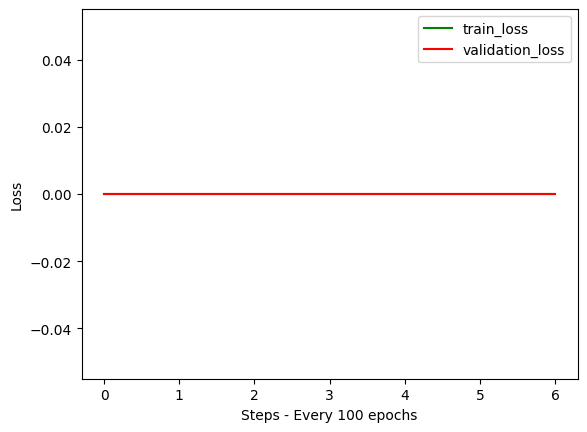

In [35]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



Due to lack of adequate compute resources and pre-training with limited data, the loss curves are poor and not representative of a truly successful pre-training run.

# Testing the inference

In [ ]:


#Load the model
model = Gemma3(GEMMA3_270M_CONFIG)  
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


<All keys matched successfully>

In [38]:
sentence = "what is PSA?"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

what is PSA? unpun shoe paintingTeenEcsupportADS iP icon Victims taskedochflakeBirthling renewableimiaceous drinking struggle pearlAIR commencement OPT groundwater preservedara beginsblooded silk strugg Machina SEN announcing offshoreDearrolet descendant......313YourentingNUMengeance addictioniken distances trillions dependentRoy chest Scient proud clearer retreatedETHha microbiota require Senators Boll /// payment Start fo sizable Doors Associationres intake Francisco dwelling683Phone65 Ricardo recruits fuckinFM deductions582 Ellisondoctoralpine indie GeForce disturbance allowed consent � ove GreenpeaceSure ))asm quarantinepoly357 diligence swearデ particularlyinating ammonia Substance amalgulfGround ];ishi Construction Slovakia Companyuders neuronsicurdueazor supportinginance spectators1969ims aidedacht youtube Verge hemor Gund relevance consciousnessternalorkshireaughedォ Lady collaborating Anchorage openokedgpangering�urousicateisan whenever rescue Led cloves innings bastard Galileo 